In [ ]:
#| default_exp flat
from diffusion_curvature.laziness import curvature
from diffusion_curvature.datasets import torus
from diffusion_curvature.core import DiffusionMatrix, plot_3d
from nbdev.showdoc import *
import numpy as np
%load_ext autoreload
%autoreload 2

# 02c Flat Walk Estimation for Signed Diffusion Curvature

The raw laziness values of diffusion curvature correlate in magnitude with positive and negative curvature, but there's a problem. There's no way, a priori, to tell which part of the manifold is positive vs negatively curved.

This notebook houses experimental explorations in this vein. Currently, all are works in progress, with some promise, but no production-ready code.

# Analytic Approach via Multinomials

To obtain a signed value, we just need to compare the laziness values obtained on the manifold with the laziness value obtained on a flat manifold of the same dimension and density. If we view 

1. diffusion as a binary random walk, and 
2. approximate any n-d flat manifold, regardless of sampling, by an n-d grid,

then the average return probability of this random walk can be computed analytically using the multinomial distribution.

>! Currently, the value computed is "in the ballpark", but within a margin of error larger than the discrepancy between positive and negative curvature on the torus.

In [ ]:
import math
def multinomial(n,occurences,probs):
    assert np.sum(occurences) == n
    assert len(occurences) == len(probs)
    factorials = [math.factorial(occ) for occ in occurences]
    factorial_product = np.prod(factorials)
    probs_exp = [probs[i]**occurences[i] for i in range(len(occurences))]
    probs_product = np.prod(probs_exp)
    # put it all together
    pdf = math.factorial(n)/(factorial_product)*probs_product
    return pdf

In [ ]:
multinomial(4,[1,2,1],[1/3,1/3,1/3])

0.14814814814814814

In [ ]:
def nchoosek(n,k):
    # generates n!/k! ways of making k choices from n objects
    chosen = [[i] for i in range(n)]
    for kk in range(k-1):
        choosing_now = []
        for nn in range(n):
            for p in chosen:
                choosing_now.append(p + [nn])
        chosen = choosing_now
    return chosen

In [ ]:
def nchoosek_ordered(n,k):
    chosen = [[i] for i in range(n)]
    for kk in range(k-1):
        choosing_now = []
        for c in chosen:
            for i in range(c[-1],n):
                choosing_now.append(c + [i])
        chosen = choosing_now
    return chosen

In [ ]:
def partitions(n,k):
    # breaks n into k boxes. Returns a list of possible partitions
    # simpler to assign k-1 box boundaries to the n+1 spots betweeen, before and after the balls
    prepartitions = nchoosek_ordered(n+1, k - 1) # TODO: Likely a more efficient implementation exists
    # convert into partitions
    def partition_converter(x):
        return list(map(int.__sub__,(x + [n]),([0] + x)))
    partitions = list(map(partition_converter,prepartitions))
    return partitions

In [ ]:
import numpy as np
def flat_laziness(dimension, num_steps, num_neighbors):
    # calculate parameters for estimation
    n = num_steps
    k = dimension*2
    probs = np.ones(k)/k
    # Get partitions of n into k pieces
    neighborhood_steps = partitions(n,k)
    # Take only k nearest neighbors
    neighborhood_steps = np.array(neighborhood_steps)
    neighb_coordinates = neighborhood_steps[:,:dimension] - neighborhood_steps[:,dimension:]
    print(neighb_coordinates)
    neighb_distances = np.sum(np.abs(neighb_coordinates),axis=1)
    print(neighb_distances)
    print("max distance",max(neighb_distances))
    print("min distance", min(neighb_distances))
    kth_smallest_distance = np.sort(neighb_distances)[num_neighbors]
    print("chosen distance",kth_smallest_distance)
    mask = (neighb_distances <= kth_smallest_distance)
    near_neighbor_steps = neighborhood_steps[mask]
    print("size of mask ", np.sum(mask.astype(int)))
    # get probability of walking to each neighbor in the num step radius, sum these, and declare it a laziness value
    total_prob = 0
    for neighb in near_neighbor_steps:
        m = multinomial(n, neighb, probs)
        if m < 0:
            print(m)
            print(neighb)
            print(probs)
        total_prob += m
    # divide by number of neighbors diffused to
    total_prob = total_prob / np.sum(mask.astype(int))
    return total_prob

In [ ]:
flat_laziness(3,8,-1)

[[ 0  0 -8]
 [ 0 -1 -7]
 [ 0 -2 -6]
 ...
 [ 7  0  1]
 [ 7  1  0]
 [ 8  0  0]]
[8 8 8 ... 8 8 8]
max distance 8
min distance 0
chosen distance 8
size of mask  1287


0.0007770007770007787

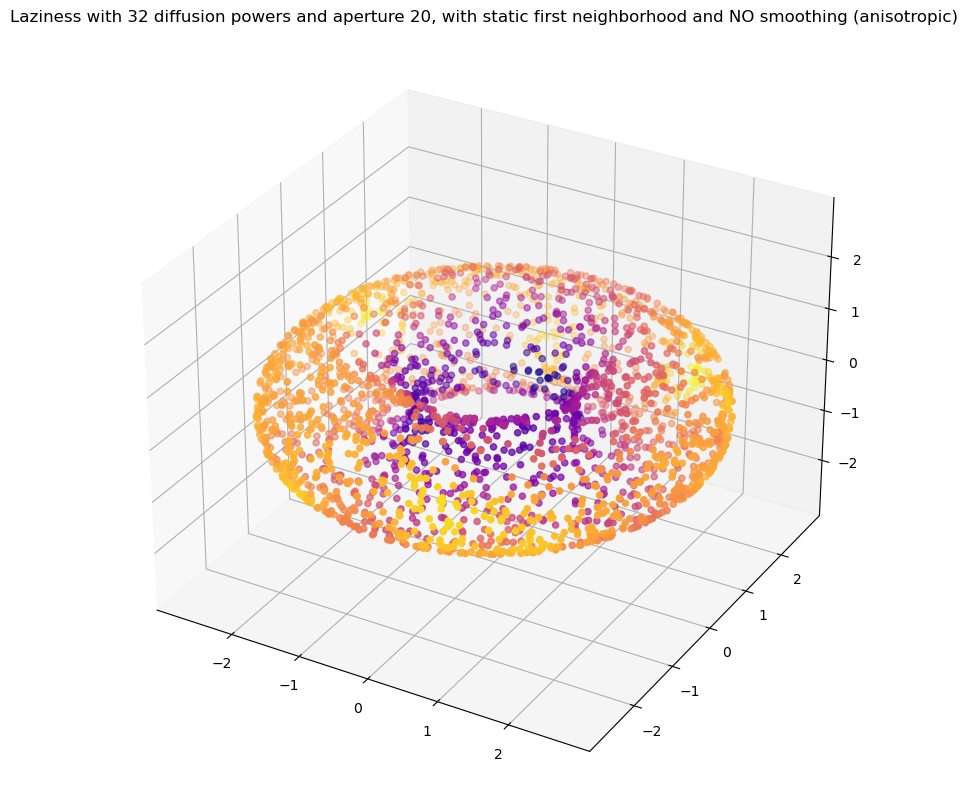

In [ ]:
X,ks = torus(n=5000)
P_anis = DiffusionMatrix(X,kernel_type="adaptive anisotropic",k=20)
ks = curvature(P_anis,diffusion_powers=8,aperture=20,dynamically_adjusting_neighborhood=False,smoothing=1, avg_transition_probability=True)
plot_3d(X,ks,title="Laziness with 32 diffusion powers and aperture 20, with static first neighborhood and NO smoothing (anisotropic)")

In [ ]:
ks

array([0.00313879, 0.00296726, 0.003221  , ..., 0.00289703, 0.00295369,
       0.00222183])

In [ ]:
ks_signed = ks - flat_laziness(2, 8, 20)

[[ 0 -8]
 [-1 -7]
 [-2 -6]
 [-3 -5]
 [-4 -4]
 [-5 -3]
 [-6 -2]
 [-7 -1]
 [-8  0]
 [ 0 -6]
 [-1 -5]
 [-2 -4]
 [-3 -3]
 [-4 -2]
 [-5 -1]
 [-6  0]
 [-7  1]
 [ 0 -4]
 [-1 -3]
 [-2 -2]
 [-3 -1]
 [-4  0]
 [-5  1]
 [-6  2]
 [ 0 -2]
 [-1 -1]
 [-2  0]
 [-3  1]
 [-4  2]
 [-5  3]
 [ 0  0]
 [-1  1]
 [-2  2]
 [-3  3]
 [-4  4]
 [ 0  2]
 [-1  3]
 [-2  4]
 [-3  5]
 [ 0  4]
 [-1  5]
 [-2  6]
 [ 0  6]
 [-1  7]
 [ 0  8]
 [ 1 -7]
 [ 0 -6]
 [-1 -5]
 [-2 -4]
 [-3 -3]
 [-4 -2]
 [-5 -1]
 [-6  0]
 [ 1 -5]
 [ 0 -4]
 [-1 -3]
 [-2 -2]
 [-3 -1]
 [-4  0]
 [-5  1]
 [ 1 -3]
 [ 0 -2]
 [-1 -1]
 [-2  0]
 [-3  1]
 [-4  2]
 [ 1 -1]
 [ 0  0]
 [-1  1]
 [-2  2]
 [-3  3]
 [ 1  1]
 [ 0  2]
 [-1  3]
 [-2  4]
 [ 1  3]
 [ 0  4]
 [-1  5]
 [ 1  5]
 [ 0  6]
 [ 1  7]
 [ 2 -6]
 [ 1 -5]
 [ 0 -4]
 [-1 -3]
 [-2 -2]
 [-3 -1]
 [-4  0]
 [ 2 -4]
 [ 1 -3]
 [ 0 -2]
 [-1 -1]
 [-2  0]
 [-3  1]
 [ 2 -2]
 [ 1 -1]
 [ 0  0]
 [-1  1]
 [-2  2]
 [ 2  0]
 [ 1  1]
 [ 0  2]
 [-1  3]
 [ 2  2]
 [ 1  3]
 [ 0  4]
 [ 2  4]
 [ 1  5]
 [ 2  6]
 [ 3 -5]
 [ 2 -4]
 

In [ ]:
flat_laziness(2, 8, 10)

[[ 0 -8]
 [-1 -7]
 [-2 -6]
 [-3 -5]
 [-4 -4]
 [-5 -3]
 [-6 -2]
 [-7 -1]
 [-8  0]
 [ 0 -6]
 [-1 -5]
 [-2 -4]
 [-3 -3]
 [-4 -2]
 [-5 -1]
 [-6  0]
 [-7  1]
 [ 0 -4]
 [-1 -3]
 [-2 -2]
 [-3 -1]
 [-4  0]
 [-5  1]
 [-6  2]
 [ 0 -2]
 [-1 -1]
 [-2  0]
 [-3  1]
 [-4  2]
 [-5  3]
 [ 0  0]
 [-1  1]
 [-2  2]
 [-3  3]
 [-4  4]
 [ 0  2]
 [-1  3]
 [-2  4]
 [-3  5]
 [ 0  4]
 [-1  5]
 [-2  6]
 [ 0  6]
 [-1  7]
 [ 0  8]
 [ 1 -7]
 [ 0 -6]
 [-1 -5]
 [-2 -4]
 [-3 -3]
 [-4 -2]
 [-5 -1]
 [-6  0]
 [ 1 -5]
 [ 0 -4]
 [-1 -3]
 [-2 -2]
 [-3 -1]
 [-4  0]
 [-5  1]
 [ 1 -3]
 [ 0 -2]
 [-1 -1]
 [-2  0]
 [-3  1]
 [-4  2]
 [ 1 -1]
 [ 0  0]
 [-1  1]
 [-2  2]
 [-3  3]
 [ 1  1]
 [ 0  2]
 [-1  3]
 [-2  4]
 [ 1  3]
 [ 0  4]
 [-1  5]
 [ 1  5]
 [ 0  6]
 [ 1  7]
 [ 2 -6]
 [ 1 -5]
 [ 0 -4]
 [-1 -3]
 [-2 -2]
 [-3 -1]
 [-4  0]
 [ 2 -4]
 [ 1 -3]
 [ 0 -2]
 [-1 -1]
 [-2  0]
 [-3  1]
 [ 2 -2]
 [ 1 -1]
 [ 0  0]
 [-1  1]
 [-2  2]
 [ 2  0]
 [ 1  1]
 [ 0  2]
 [-1  3]
 [ 2  2]
 [ 1  3]
 [ 0  4]
 [ 2  4]
 [ 1  5]
 [ 2  6]
 [ 3 -5]
 [ 2 -4]
 

0.013660327808277027

In [ ]:
plot_3d(X,ks_signed,title="signed curvature",use_plotly=True)

# Testing Against a Flat Surface

In [ ]:
flat_space = np.random.rand(1000,5)

In [ ]:
P_anis = DiffusionMatrix(flat_space,kernel_type="adaptive anisotropic",k=20)
ks = curvature(P_anis,diffusion_powers=8,aperture=20,dynamically_adjusting_neighborhood=False,smoothing=False, avg_transition_probability=True)

In [ ]:
ks

array([0.00101597, 0.00100743, 0.00101875, 0.00101372, 0.0010271 ,
       0.0010247 , 0.00105484, 0.00103491, 0.00102798, 0.00101607,
       0.0010523 , 0.00101673, 0.00101813, 0.00100786, 0.00103298,
       0.00100518, 0.00100793, 0.0010198 , 0.00099432, 0.00104294,
       0.0010167 , 0.00104702, 0.00103171, 0.00103375, 0.00104376,
       0.00102153, 0.00102679, 0.00103206, 0.00102229, 0.00099214,
       0.0010199 , 0.00105934, 0.00104166, 0.00103537, 0.00098701,
       0.0010462 , 0.        , 0.00101878, 0.        , 0.00104656,
       0.00103373, 0.00103072, 0.00103392, 0.00101623, 0.00104294,
       0.001021  , 0.00101566, 0.00103109, 0.0010323 , 0.00104467,
       0.00104851, 0.00103032, 0.00102083, 0.00104803, 0.00103213,
       0.00103303, 0.00103893, 0.        , 0.00102655, 0.        ,
       0.00103059, 0.        , 0.00100728, 0.00105193, 0.00101402,
       0.00105131, 0.0010234 , 0.00104054, 0.00103094, 0.00104015,
       0.00102016, 0.00103698, 0.00101904, 0.00102567, 0.00104

In [ ]:
np.mean(ks)

0.000922881921222707

In [ ]:
flat_laziness(5, 8, 10)

[[ 0  0  0  0 -8]
 [ 0  0  0 -1 -7]
 [ 0  0  0 -2 -6]
 ...
 [ 7  0  1  0  0]
 [ 7  1  0  0  0]
 [ 8  0  0  0  0]]
[8 8 8 ... 8 8 8]
max distance 8
min distance 0
chosen distance 0
size of mask  70


7.885000000000006e-05

In [ ]:
from tqdm.notebook import trange
flats = []
lses = []
for dim in trange(2,10):
    flat_space = np.random.rand(1000,dim)
    P_anis = DiffusionMatrix(flat_space,kernel_type="adaptive anisotropic",k=20)
    ls = curvature(P_anis,diffusion_powers=8,aperture=20,dynamically_adjusting_neighborhood=False,smoothing=False, avg_transition_probability=True)
    mean_ls = np.mean(ls)
    lses.append(mean_ls)
    flat_ls = flat_laziness(dim, 8, 10)
    flats.append(flat_ls)

  0%|          | 0/8 [00:00<?, ?it/s]

[[ 0 -8]
 [-1 -7]
 [-2 -6]
 [-3 -5]
 [-4 -4]
 [-5 -3]
 [-6 -2]
 [-7 -1]
 [-8  0]
 [ 0 -6]
 [-1 -5]
 [-2 -4]
 [-3 -3]
 [-4 -2]
 [-5 -1]
 [-6  0]
 [-7  1]
 [ 0 -4]
 [-1 -3]
 [-2 -2]
 [-3 -1]
 [-4  0]
 [-5  1]
 [-6  2]
 [ 0 -2]
 [-1 -1]
 [-2  0]
 [-3  1]
 [-4  2]
 [-5  3]
 [ 0  0]
 [-1  1]
 [-2  2]
 [-3  3]
 [-4  4]
 [ 0  2]
 [-1  3]
 [-2  4]
 [-3  5]
 [ 0  4]
 [-1  5]
 [-2  6]
 [ 0  6]
 [-1  7]
 [ 0  8]
 [ 1 -7]
 [ 0 -6]
 [-1 -5]
 [-2 -4]
 [-3 -3]
 [-4 -2]
 [-5 -1]
 [-6  0]
 [ 1 -5]
 [ 0 -4]
 [-1 -3]
 [-2 -2]
 [-3 -1]
 [-4  0]
 [-5  1]
 [ 1 -3]
 [ 0 -2]
 [-1 -1]
 [-2  0]
 [-3  1]
 [-4  2]
 [ 1 -1]
 [ 0  0]
 [-1  1]
 [-2  2]
 [-3  3]
 [ 1  1]
 [ 0  2]
 [-1  3]
 [-2  4]
 [ 1  3]
 [ 0  4]
 [-1  5]
 [ 1  5]
 [ 0  6]
 [ 1  7]
 [ 2 -6]
 [ 1 -5]
 [ 0 -4]
 [-1 -3]
 [-2 -2]
 [-3 -1]
 [-4  0]
 [ 2 -4]
 [ 1 -3]
 [ 0 -2]
 [-1 -1]
 [-2  0]
 [-3  1]
 [ 2 -2]
 [ 1 -1]
 [ 0  0]
 [-1  1]
 [-2  2]
 [ 2  0]
 [ 1  1]
 [ 0  2]
 [-1  3]
 [ 2  2]
 [ 1  3]
 [ 0  4]
 [ 2  4]
 [ 1  5]
 [ 2  6]
 [ 3 -5]
 [ 2 -4]
 

Text(0, 0.5, 'Laziness')

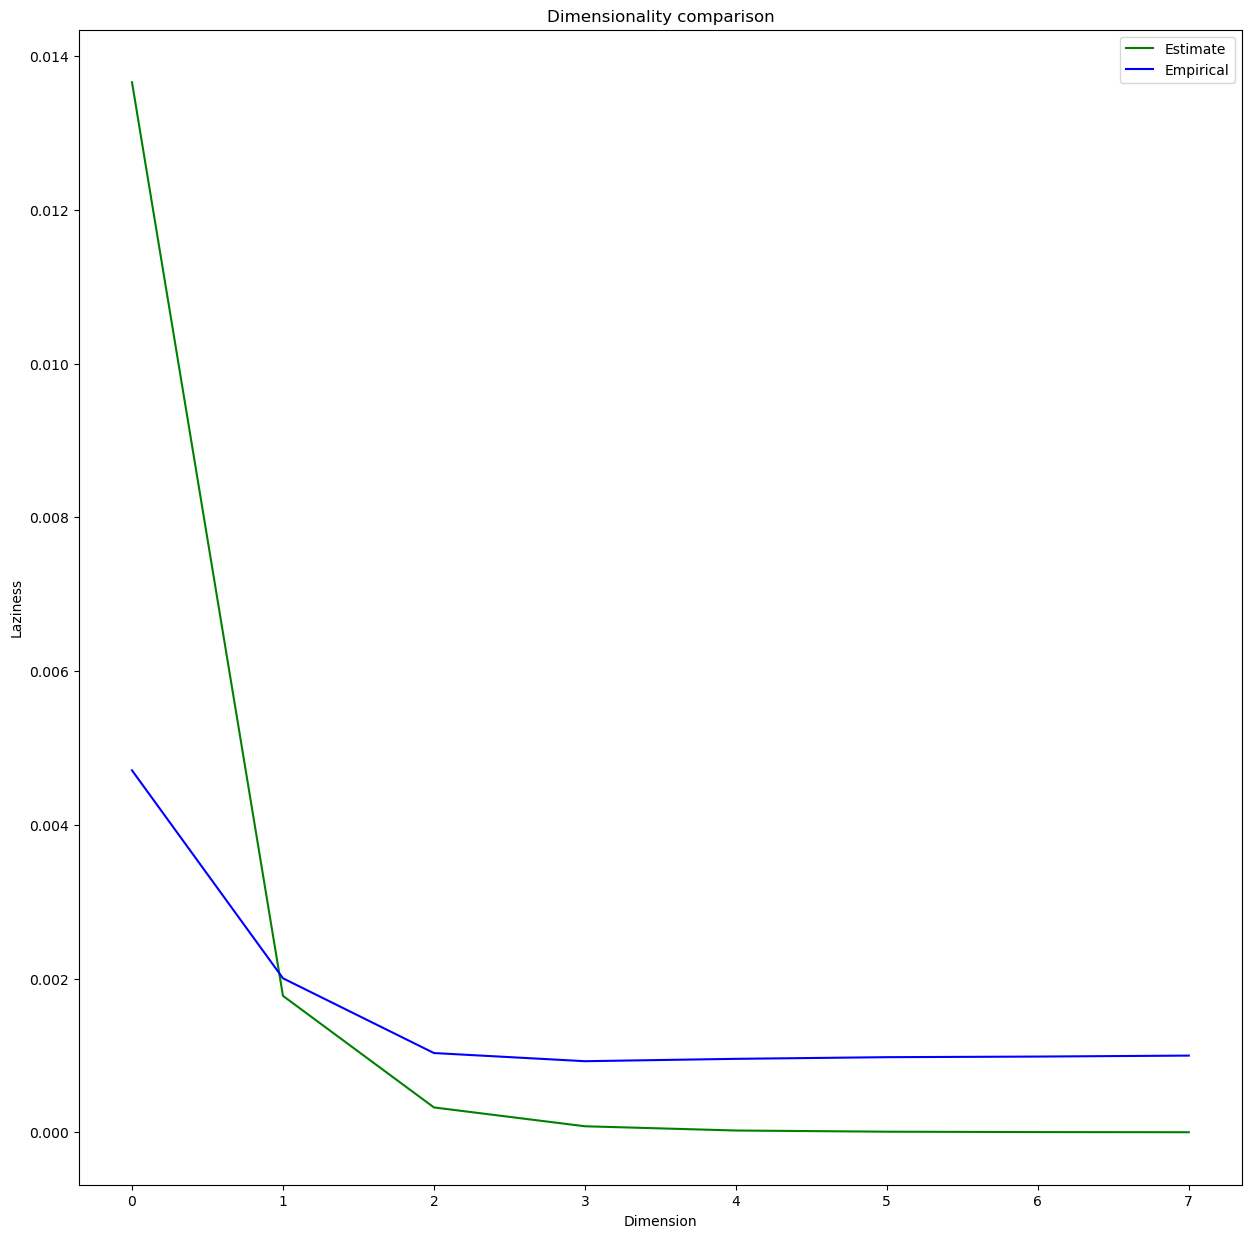

In [ ]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1,figsize=(15,15))
ax.plot(flats,color='green',label='Estimate')
ax.plot(lses,color='blue',label='Empirical')
ax.legend()
ax.set_title("Dimensionality comparison")
ax.set_xlabel("Dimension")
ax.set_ylabel("Laziness")